# C25 vs. SP500

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import numpy as np
from sklearn.ensemble import RandomForestClassifier


In [142]:
df_sp500 = pd.read_csv('/Users/lassekh/Downloads/sp500.csv')
df_c25 = pd.read_excel('/Users/lassekh/Downloads/EODHist_20101220-20241009_OMXC25.xlsx')

In [143]:
df_sp500

,Date,Close/Last,Open,High,Low
0,10/07/2024,5695.94,5737.80,5739.34,5686.85
1,10/04/2024,5751.07,5737.48,5753.21,5702.83
2,10/03/2024,5699.94,5698.19,5718.78,5677.37
3,10/02/2024,5709.54,5698.14,5719.63,5674.00
4,10/01/2024,5708.75,5757.73,5757.73,5681.28
...,...,...,...,...,...
2522,10/14/2014,1877.70,1877.11,1898.71,1871.79
2523,10/13/2014,1874.74,1905.65,1912.09,1874.14
2524,10/10/2014,1906.13,1925.63,1936.98,1906.05
2525,10/09/2014,1928.21,1967.68,1967.68,1927.56


In [144]:
df_c25

,Trade Date,Index Value,Net Change,High,Low
0,2024-10-09,0.000000,0.000000,0.000000,0.000000
1,2024-10-08,1942.012623,4.257684,1948.941892,1924.925075
2,2024-10-07,1937.754940,21.572329,1938.147366,1910.903601
3,2024-10-04,1916.182611,5.042233,1932.215445,1909.173594
4,2024-10-03,1911.140378,-14.232112,1923.973828,1908.612972
...,...,...,...,...,...
3450,2010-12-27,544.353310,0.000000,0.000000,0.000000
3451,2010-12-23,546.605932,0.000000,0.000000,0.000000
3452,2010-12-22,542.778001,0.000000,0.000000,0.000000
3453,2010-12-21,544.980134,0.000000,0.000000,0.000000


In [146]:
df_c25['Date'] = pd.to_datetime(df_c25['Trade Date'])
df_c25 = df_c25.drop(columns='Trade Date')
df_c25.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3455 entries, 0 to 3454
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Index Value  3455 non-null   float64       
 1   Net Change   3455 non-null   float64       
 2   High         3455 non-null   float64       
 3   Low          3455 non-null   float64       
 4   Date         3455 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4)
memory usage: 135.1 KB


In [147]:
df_sp500['Date'] = pd.to_datetime(df_sp500['Date'])
df_sp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2527 entries, 0 to 2526
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2527 non-null   datetime64[ns]
 1   Close/Last  2527 non-null   float64       
 2   Open        2527 non-null   float64       
 3   High        2527 non-null   float64       
 4   Low         2527 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 98.8 KB


In [162]:
df = pd.merge(df_sp500, df_c25, how='outer', on='Date', suffixes=('_sp500', '_c25'))
df = df.sort_values(by='Date').reset_index(drop=True)
df

,Date,Close/Last,Open,High_sp500,Low_sp500,Index Value,Net Change,High_c25,Low_c25
0,2010-12-20,NaN,NaN,NaN,NaN,542.094259,0.000000,0.000000,0.000000
1,2010-12-21,NaN,NaN,NaN,NaN,544.980134,0.000000,0.000000,0.000000
2,2010-12-22,NaN,NaN,NaN,NaN,542.778001,0.000000,0.000000,0.000000
3,2010-12-23,NaN,NaN,NaN,NaN,546.605932,0.000000,0.000000,0.000000
4,2010-12-27,NaN,NaN,NaN,NaN,544.353310,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
3532,2024-10-03,5699.94,5698.19,5718.78,5677.37,1911.140378,-14.232112,1923.973828,1908.612972
3533,2024-10-04,5751.07,5737.48,5753.21,5702.83,1916.182611,5.042233,1932.215445,1909.173594
3534,2024-10-07,5695.94,5737.80,5739.34,5686.85,1937.754940,21.572329,1938.147366,1910.903601
3535,2024-10-08,NaN,NaN,NaN,NaN,1942.012623,4.257684,1948.941892,1924.925075


In [163]:
df = df.dropna().reset_index(drop=True)

In [164]:
df.loc[df['Net Change'] == 0, 'Net Change'] = df['Index Value'] - df['Index Value'].shift(1)
df

,Date,Close/Last,Open,High_sp500,Low_sp500,Index Value,Net Change,High_c25,Low_c25
0,2014-10-08,1968.89,1935.55,1970.36,1925.25,767.431247,NaN,0.000000,0.000000
1,2014-10-09,1928.21,1967.68,1967.68,1927.56,764.928717,-2.502529,0.000000,0.000000
2,2014-10-10,1906.13,1925.63,1936.98,1906.05,750.032813,-14.895904,0.000000,0.000000
3,2014-10-13,1874.74,1905.65,1912.09,1874.14,746.560781,-3.472032,0.000000,0.000000
4,2014-10-14,1877.70,1877.11,1898.71,1871.79,749.100715,2.539934,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2440,2024-10-01,5708.75,5757.73,5757.73,5681.28,1924.971289,-24.894807,1952.837177,1921.019392
2441,2024-10-02,5709.54,5698.14,5719.63,5674.00,1925.372490,0.401201,1935.508701,1913.108207
2442,2024-10-03,5699.94,5698.19,5718.78,5677.37,1911.140378,-14.232112,1923.973828,1908.612972
2443,2024-10-04,5751.07,5737.48,5753.21,5702.83,1916.182611,5.042233,1932.215445,1909.173594


In [165]:
df = df.dropna()

In [168]:
df = df.rename(columns={'Close/Last':'LAST_CLOSE_SP500', 'Index Value':'LAST_CLOSE_C25', 'Net Change':'CHANGE_C25'})

## Feature engineering

In [266]:
df.columns

Index(['Date', 'LAST_CLOSE_SP500', 'Open', 'High_sp500', 'Low_sp500',
       'LAST_CLOSE_C25', 'CHANGE_C25', 'High_c25', 'Low_c25', 'CHANGE_SP500',
       'C25_MOVEMENT', 'SP500_MOVEMENT_SAME_DAY', 'C25_MOVEMENT_YESTERDAY',
       'CSP500_MOVEMENT_YESTERDAY', 'SP500_MOVEMENT_YESTERDAY',
       'C25_CLOSE_RATIO_3', 'Trend_3', 'C25_CLOSE_RATIO_5', 'Trend_5',
       'C25_CLOSE_RATIO_10', 'Trend_10', 'C25_CLOSE_RATIO_15', 'Trend_15',
       'C25_CLOSE_RATIO_20', 'Trend_20', 'C25_CLOSE_RATIO_65', 'Trend_65',
       'C25_CLOSE_RATIO_130', 'Trend_130', 'C25_CLOSE_RATIO_260', 'Trend_260'],
      dtype='object')

In [176]:
df['CHANGE_SP500'] = df['LAST_CLOSE_SP500'] - df['LAST_CLOSE_SP500'].shift(1)
df['C25_MOVEMENT'] = (df['CHANGE_C25'] > 0).astype(int)
df['SP500_MOVEMENT_SAME_DAY'] = df['CHANGE_SP500'].shift(1)
df['C25_MOVEMENT_YESTERDAY'] = df['C25_MOVEMENT'].shift(1)
df['SP500_MOVEMENT_YESTERDAY'] = df['CHANGE_SP500'].shift(2)
df

,Date,LAST_CLOSE_SP500,Open,High_sp500,Low_sp500,LAST_CLOSE_C25,CHANGE_C25,High_c25,Low_c25,CHANGE_SP500,C25_MOVEMENT,SP500_MOVEMENT_SAME_DAY,C25_MOVEMENT_YESTERDAY,CSP500_MOVEMENT_YESTERDAY,SP500_MOVEMENT_YESTERDAY
1,2014-10-09,1928.21,1967.68,1967.68,1927.56,764.928717,-2.502529,0.000000,0.000000,NaN,0,NaN,NaN,NaN,NaN
2,2014-10-10,1906.13,1925.63,1936.98,1906.05,750.032813,-14.895904,0.000000,0.000000,-22.08,0,NaN,0.0,NaN,NaN
3,2014-10-13,1874.74,1905.65,1912.09,1874.14,746.560781,-3.472032,0.000000,0.000000,-31.39,0,-22.08,0.0,NaN,NaN
4,2014-10-14,1877.70,1877.11,1898.71,1871.79,749.100715,2.539934,0.000000,0.000000,2.96,1,-31.39,0.0,-22.08,-22.08
5,2014-10-15,1862.49,1874.18,1874.18,1820.66,732.529282,-16.571434,0.000000,0.000000,-15.21,0,2.96,1.0,-31.39,-31.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2440,2024-10-01,5708.75,5757.73,5757.73,5681.28,1924.971289,-24.894807,1952.837177,1921.019392,-53.73,0,24.31,0.0,-7.20,-7.20
2441,2024-10-02,5709.54,5698.14,5719.63,5674.00,1925.372490,0.401201,1935.508701,1913.108207,0.79,1,-53.73,0.0,24.31,24.31
2442,2024-10-03,5699.94,5698.19,5718.78,5677.37,1911.140378,-14.232112,1923.973828,1908.612972,-9.60,0,0.79,1.0,-53.73,-53.73
2443,2024-10-04,5751.07,5737.48,5753.21,5702.83,1916.182611,5.042233,1932.215445,1909.173594,51.13,1,-9.60,0.0,0.79,0.79


In [177]:
df.dropna()

,Date,LAST_CLOSE_SP500,Open,High_sp500,Low_sp500,LAST_CLOSE_C25,CHANGE_C25,High_c25,Low_c25,CHANGE_SP500,C25_MOVEMENT,SP500_MOVEMENT_SAME_DAY,C25_MOVEMENT_YESTERDAY,CSP500_MOVEMENT_YESTERDAY,SP500_MOVEMENT_YESTERDAY
4,2014-10-14,1877.70,1877.11,1898.71,1871.79,749.100715,2.539934,0.000000,0.000000,2.96,1,-31.39,0.0,-22.08,-22.08
5,2014-10-15,1862.49,1874.18,1874.18,1820.66,732.529282,-16.571434,0.000000,0.000000,-15.21,0,2.96,1.0,-31.39,-31.39
6,2014-10-16,1862.76,1855.95,1876.01,1835.02,719.147913,-13.381369,0.000000,0.000000,0.27,0,-15.21,0.0,2.96,2.96
7,2014-10-17,1886.76,1864.91,1898.16,1864.91,745.984281,26.836369,0.000000,0.000000,24.00,1,0.27,0.0,-15.21,-15.21
8,2014-10-20,1904.01,1885.62,1905.03,1882.30,748.677168,2.692886,0.000000,0.000000,17.25,1,24.00,1.0,0.27,0.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2440,2024-10-01,5708.75,5757.73,5757.73,5681.28,1924.971289,-24.894807,1952.837177,1921.019392,-53.73,0,24.31,0.0,-7.20,-7.20
2441,2024-10-02,5709.54,5698.14,5719.63,5674.00,1925.372490,0.401201,1935.508701,1913.108207,0.79,1,-53.73,0.0,24.31,24.31
2442,2024-10-03,5699.94,5698.19,5718.78,5677.37,1911.140378,-14.232112,1923.973828,1908.612972,-9.60,0,0.79,1.0,-53.73,-53.73
2443,2024-10-04,5751.07,5737.48,5753.21,5702.83,1916.182611,5.042233,1932.215445,1909.173594,51.13,1,-9.60,0.0,0.79,0.79


In [261]:
# Create rolling averages
days = [3, 5, 10, 15, 20, 65, 130, 260] # 3 days, 1,2,3,4 weeks, 3,6,12 months

for num in days:
    # To calculate the rolling average for days for the data frame
    rolling_avg = df.drop(columns='Date').rolling(num).mean()
    # Then we use the rolling average for the LAST_CLOSE_SP500 and _C25
    # to see the ratio between the close today and days ago
    #df[f'SP500_CLOSE_RATIO_{num}'] = df['LAST_CLOSE_SP500'] / rolling_avg['LAST_CLOSE_SP500']
    ratio_feature = f'C25_CLOSE_RATIO_{num}'
    df[ratio_feature] = df['LAST_CLOSE_C25'] / rolling_avg['LAST_CLOSE_C25']
    
    # Takes the trend of the change over X-days and adds the result to next row
    trend_feature = f'Trend_{num}'
    df[trend_feature] = df.drop(columns='Date').shift(1).rolling(num).sum()['C25_MOVEMENT']

df

,Date,LAST_CLOSE_SP500,Open,High_sp500,Low_sp500,LAST_CLOSE_C25,CHANGE_C25,High_c25,Low_c25,CHANGE_SP500,...,C25_CLOSE_RATIO_15,Trend_15,C25_CLOSE_RATIO_20,Trend_20,C25_CLOSE_RATIO_65,Trend_65,C25_CLOSE_RATIO_130,Trend_130,C25_CLOSE_RATIO_260,Trend_260
1,2014-10-09,1928.21,1967.68,1967.68,1927.56,764.928717,-2.502529,0.000000,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-10-10,1906.13,1925.63,1936.98,1906.05,750.032813,-14.895904,0.000000,0.000000,-22.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-10-13,1874.74,1905.65,1912.09,1874.14,746.560781,-3.472032,0.000000,0.000000,-31.39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-10-14,1877.70,1877.11,1898.71,1871.79,749.100715,2.539934,0.000000,0.000000,2.96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2014-10-15,1862.49,1874.18,1874.18,1820.66,732.529282,-16.571434,0.000000,0.000000,-15.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2440,2024-10-01,5708.75,5757.73,5757.73,5681.28,1924.971289,-24.894807,1952.837177,1921.019392,-53.73,...,0.968500,6.0,0.971659,7.0,0.978046,33.0,0.983708,69.0,1.032550,144.0
2441,2024-10-02,5709.54,5698.14,5719.63,5674.00,1925.372490,0.401201,1935.508701,1913.108207,0.79,...,0.970259,6.0,0.973181,7.0,0.978602,33.0,0.983933,68.0,1.032344,143.0
2442,2024-10-03,5699.94,5698.19,5718.78,5677.37,1911.140378,-14.232112,1923.973828,1908.612972,-9.60,...,0.966295,6.0,0.967248,8.0,0.971725,33.0,0.976777,68.0,1.024299,143.0
2443,2024-10-04,5751.07,5737.48,5753.21,5702.83,1916.182611,5.042233,1932.215445,1909.173594,51.13,...,0.972894,5.0,0.970765,8.0,0.974683,33.0,0.979462,67.0,1.026577,143.0


In [264]:
df = df.dropna()

In [265]:
df['C25_MOVEMENT'].value_counts()

C25_MOVEMENT
1    1157
0    1027
Name: count, dtype: int64

In [174]:
# Function to train and evaluate model using TimeSeriesSplit
def evaluate_model(model, X, y, max_splits):
    # Initialize variables to store results
    best_n_splits = None
    best_accuracy = 0
    results = {}

    # Test different n_splits values
    for n_splits in range(2, max_splits):  # Testing from 2 to max_splits
        tscv = TimeSeriesSplit(n_splits=n_splits)
        accuracies = []

        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Train the model
            model.fit(X_train, y_train)

            # Predict on test data
            y_pred = model.predict(X_test)

            # Evaluate the model
            accuracy = accuracy_score(y_test, y_pred)
            accuracies.append(accuracy)

        # Calculate the average accuracy for this n_splits
        average_accuracy = np.mean(accuracies)
        results[n_splits] = average_accuracy

        # Update the best n_splits if the current one is better
        if average_accuracy > best_accuracy:
            best_accuracy = average_accuracy
            best_n_splits = n_splits

    return best_n_splits, best_accuracy

In [198]:
columns_to_drop = ['Date', 'LAST_CLOSE_SP500', 'Open', 'High_sp500', 'Low_sp500',
       'LAST_CLOSE_C25', 'CHANGE_C25', 'High_c25', 'Low_c25', 'CHANGE_SP500',
       'C25_MOVEMENT',
       #'SP500_MOVEMENT_SAME_DAY'
       #'C25_MOVEMENT_YESTERDAY',
       #'SP500_MOVEMENT_YESTERDAY'
    ]

Best n_splits: 11 with Average Accuracy: 0.57
tests result of y_pred vs x test. Final Accuracy on last fold with best n_splits: 0.56


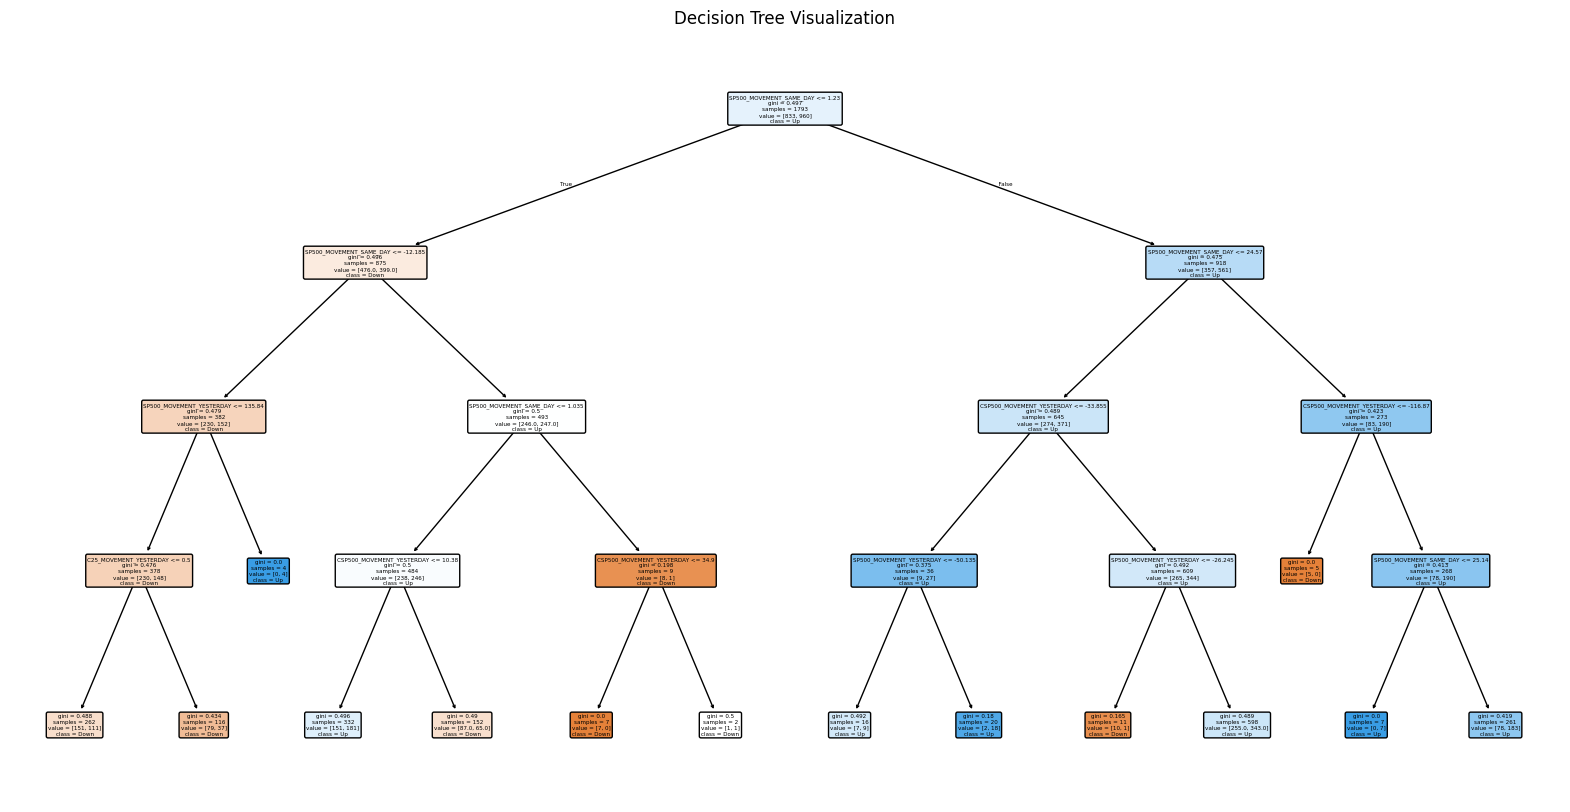

In [247]:
# Model
max_splits = 20
dt_model = DecisionTreeClassifier(max_depth=4, random_state=42)
# Fjern irrelevante kolonner og angiv den afhængige variabel
X = df.drop(columns=columns_to_drop)
y = df['C25_MOVEMENT']

# Data split
train_size = 0.8
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=False)

best_n_splits, best_accuracy = evaluate_model(dt_model, X_train, y_train, max_splits)

# Udskriv resultaterne
print(f"Best n_splits: {best_n_splits} with Average Accuracy: {best_accuracy:.2f}")

# Endelig træning med den bedste n_splits
tscv = TimeSeriesSplit(n_splits=best_n_splits)
#model_dt = DecisionTreeClassifier(max_depth=depth_max, random_state=42)

for train_index, val_index in tscv.split(X_train):
    X_train_split, X_val_split = X.iloc[train_index], X.iloc[val_index]
    y_train_split, y_val_split = y.iloc[train_index], y.iloc[val_index]
    
    # Træn modellen
    dt_model.fit(X_train_split, y_train_split)
    
    # Forudsige på testdata
    y_pred = dt_model.predict(X_val_split)

#print(y_pred)
# Udfør den endelige evaluering
y_test_pred = dt_model.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"tests result of y_pred vs x test. Final Accuracy on last fold with best n_splits: {accuracy:.2f}")

# Visualisér Decision Tree
plt.figure(figsize=(20,10))
plot_tree(dt_model, feature_names=X.columns, class_names=['Down', 'Up'], filled=True, rounded=True)
plt.title('Decision Tree Visualization')
plt.show()

Confusion Matrix:
[[106 118]
 [ 95 170]]


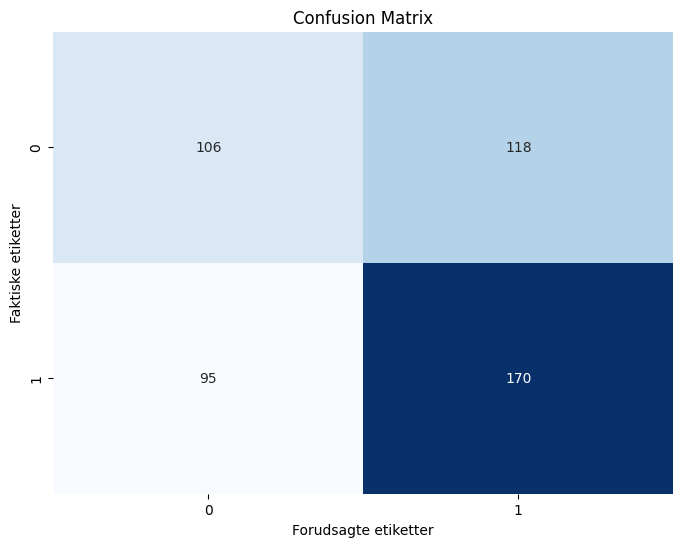

In [249]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Visualisering af Confusion Matrix som heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Forudsagte etiketter")
plt.ylabel("Faktiske etiketter")
plt.show()

## Random Forrest Classifier

In [267]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)
train = df.iloc[:-100]
test = df.iloc[-100:]
predictors = [#'Date',
       #'LAST_CLOSE_SP500',
       #'Open', 'High_sp500', 'Low_sp500',
       #'LAST_CLOSE_C25', #'CHANGE_C25', 'High_c25', 'Low_c25', 'CHANGE_SP500',
       #'C25_MOVEMENT',
       'SP500_MOVEMENT_SAME_DAY',
       'C25_MOVEMENT_YESTERDAY',
       'SP500_MOVEMENT_YESTERDAY',
       'C25_CLOSE_RATIO_3', 'Trend_3', 'C25_CLOSE_RATIO_5', 'Trend_5',
       'C25_CLOSE_RATIO_10', 'Trend_10', 'C25_CLOSE_RATIO_15', 'Trend_15',
       'C25_CLOSE_RATIO_20', 'Trend_20', 'C25_CLOSE_RATIO_65', 'Trend_65',
       'C25_CLOSE_RATIO_130', 'Trend_130', 'C25_CLOSE_RATIO_260', 'Trend_260']
#target = ['C25_CLOSE_MOVEMENT']

model.fit(train[predictors], train['C25_MOVEMENT'])

RandomForestClassifier(min_samples_split=50, n_estimators=200, random_state=1)

In [268]:
test['C25_MOVEMENT'].value_counts()

C25_MOVEMENT
1    52
0    48
Name: count, dtype: int64

In [269]:
preds = model.predict(test[predictors])

In [270]:
preds = pd.Series(preds, index=test.index)

In [271]:
preds

2345    1
2346    1
2347    1
2348    1
2349    0
       ..
2440    0
2441    0
2442    0
2443    1
2444    1
Length: 100, dtype: int64

In [272]:
precision_score(test['C25_MOVEMENT'], preds)

0.8627450980392157

In [273]:
print(f"Predictions distribution: {np.bincount(preds)}")


Predictions distribution: [49 51]


In [274]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['C25_MOVEMENT'])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name='Predictions')
    combined = pd.concat([test['C25_MOVEMENT'], preds], axis=1)
    return combined

In [275]:
def backtest(data, model, predictors, start=1250, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [276]:
predictions = backtest(df, model, predictors)
predictions['Predictions'].value_counts()

Predictions
1    487
0    447
Name: count, dtype: int64

In [277]:
precision_score(predictions['C25_MOVEMENT'], predictions['Predictions'])

0.891170431211499

In [285]:
def predict_probability(train, test, predictors, model):
    model.fit(train[predictors], train['C25_MOVEMENT'])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .9] = 1
    preds[preds < .9] = 0
    preds = pd.Series(preds, index=test.index, name='Predictions')
    combined = pd.concat([test['C25_MOVEMENT'], preds], axis=1)
    return combined

In [298]:
def backtest_probability(data, model, predictors, start=1000, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step): #starts at row 1000, stops at data frame size, increments by 250 for each loop
        train = data.iloc[0:i].copy() #from 1000:1250 (first loop)
        test = data.iloc[i:(i+step)].copy() #from 1250:1500 (first loop)
        predictions = predict_probability(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [289]:
df.shape[0]

2184

In [299]:
predictions = backtest_probability(df, model, predictors)

In [300]:
predictions['Predictions'].value_counts()

Predictions
0.0    852
1.0    332
Name: count, dtype: int64

In [301]:
precision_score(predictions['C25_MOVEMENT'], predictions['Predictions'])

0.9728915662650602